In [33]:
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import copy

# Manipulate the Data into a Usable Format

For X matrix:

In [9]:
X0 = sp.io.loadmat('X48_0T.mat')['X_data_0T']
X_avg = copy.deepcopy(X0)
num_col = len(X0[0, :])
num_row = len(X0[:, 0])
for col in range(num_col): # columns
    Num_NonZero = 0
    for row in range(num_row): # rows
        if X0[row, col] == 0:
            Num_NonZero = Num_NonZero + 1
    if Num_NonZero != 25:
        Row_Avg = np.mean(X0[:,col])*25/(25-Num_NonZero)

        for row in range(num_row): # rows
            if X0[row, col] == 0:
                X_avg[row, col] = Row_Avg;
print('X with zeros\n\n', X0)
print('\nX with averages\n\n', X_avg)

X with zeros

 [[5.72387791 2.52134585 3.93073678 ... 0.         3.43214989 0.        ]
 [5.75481033 3.0397377  3.95931864 ... 0.         0.         0.        ]
 [6.4440918  3.59008694 3.56273603 ... 2.37579942 2.11841154 0.        ]
 ...
 [5.39483166 3.5583303  3.4165566  ... 0.         0.         0.        ]
 [5.02169514 3.87967634 3.37924719 ... 0.         0.         2.22802568]
 [5.0630908  3.98612881 4.14207935 ... 0.         0.         0.        ]]

X with averages

 [[5.72387791 2.52134585 3.93073678 ... 2.546655   3.43214989 2.92841819]
 [5.75481033 3.0397377  3.95931864 ... 2.546655   3.32148784 2.92841819]
 [6.4440918  3.59008694 3.56273603 ... 2.37579942 2.11841154 2.92841819]
 ...
 [5.39483166 3.5583303  3.4165566  ... 2.546655   3.32148784 2.92841819]
 [5.02169514 3.87967634 3.37924719 ... 2.546655   3.32148784 2.22802568]
 [5.0630908  3.98612881 4.14207935 ... 2.546655   3.32148784 2.92841819]]


(25, 41094)

For Y matrix:

In [13]:
Y = sp.io.loadmat('Y48_T.mat')['Y_data_T'] # function_workspace isn't right

Time48 = Y[:, 0] # measurement time
Dose48 = Y[:,1] # radiation exposure in Gray
Patients48 = Y[:, 2]; # patient number

[0.5 0.  2.  5.  8.  0.5 0.  2.  5.  8.  0.5 0.  2.  5.  8.  0.5 0.  2.
 5.  8.  0.5 0.  2.  5.  8. ]


(25,)

Normalize both the X and Y data for PLSR

In [52]:
X0norm = np.zeros((25,41094))
for c in range(41094):
    if np.sum(X0[:,c]) != 0:
        X0norm[:,c] = sp.stats.zscore(X0[:,c])  # normalize the X data
Dose48norm = sp.stats.zscore(Dose48)  # normalize the Y data

Do PLSR on the normalized data:

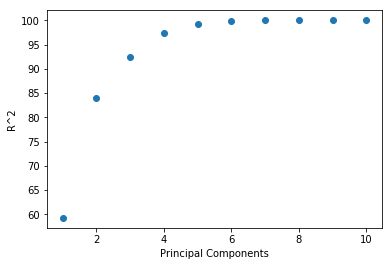

In [55]:
variance_array = np.zeros(10) # calculate variance with different numbers of PLSR
for i in range(1,11):
    plsri = PLSRegression(n_components=i)
    plsri.fit(X0norm,Dose48norm)
    variance_array[i-1] = 100*plsri.score(X0norm,Dose48norm)
plt.scatter(range(1,11),variance_array)

# need to use plsri.predict in order to predict -> use arbitrary thresholds to categorize into 
#plt.plot(range(1,11),line)
plt.xlabel("Principal Components")
plt.ylabel("R^2")
plt.show()